# Attention Exploration

In this notebook, through visualization and experimentation, we examine attention output from various huggingface Transformer implementations and fine-tunings to gathering a better understanding of working with these models and their output, including resultant attention matrices.

In [ ]:
!pip install sentencepiece
!pip install transformers

In [ ]:
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install wget

In [1]:
import numpy as np, sklearn as sk
import sklearn.metrics as SM
import numpy.linalg as LA
import matplotlib.pyplot as plt
import scipy.spatial as sp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls drive/MyDrive/Colab\ Notebooks/

In [ ]:
!tar -xzvf drive/MyDrive/Colab\ Notebooks/bert_model.tar.gz -C drive/MyDrive/Colab\ Notebooks/

./p/model_save/
./p/model_save/tokenizer_config.json
./p/model_save/config.json
./p/model_save/pytorch_model.bin
./p/model_save/vocab.txt
./p/model_save/special_tokens_map.json


In [2]:
from transformers import BertForSequenceClassification, BertTokenizer

In [3]:
model_folder = 'p/model_save/'

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_folder, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_folder)

In [ ]:
import wget
import os

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
5115,ks08,0,*,This matter was on which I consulted with the ...
6824,m_02,1,NaN,The cup was broken by Louise.
7478,sks13,0,*,John not liked Mary.
1264,r-67,1,NaN,I screamed at some children who were watching me.
3766,ks08,1,NaN,My mother baked a cake for me.
2443,l-93,1,NaN,A flowering plant is on the windowsill.
1686,r-67,0,*,John's I stole bike.
505,bc01,1,NaN,We would prefer John to be the candidate.
3215,l-93,1,NaN,The room reeked.
83,gj04,0,*,The elevator rumbled itself to the ground.


In [ ]:
import torch

sentences = df.sentence.values
labels = df.label.values
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 16,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
tokenizer.decode(input_ids[12])

'[CLS] bill rolled out of the room. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
input = input_ids[12].unsqueeze(0)

In [ ]:
output = model(input)

In [ ]:
output.keys()

odict_keys(['logits', 'attentions'])

In [ ]:
len(output.attentions[0][0][0][0])

16

In [ ]:
def get_layers(attention, num_layers=12, num_heads=12):
  layers = np.ndarray((num_heads,num_layers), np.ndarray)
  for i, layer in enumerate(attention):
    layer = layer.detach().cpu().numpy()[0]
    for j, head in enumerate(layer):
      layers[i,j] = head
  return layers
   

In [ ]:
def our_similarity(ph,qh):
  dot_product = np.inner(ph, qh)
  norm_ph = LA.norm(ph)
  norm_qh = LA.norm(qh)
  res = dot_product / (norm_ph * norm_qh)
  return res

In [ ]:
def per_head(layers, fn):
  max = np.ndarray((12,12), float)

  for layer in range(0,12):
    for head in range (0,12):
      max[layer, head] = fn(layers[layer, head])
    
  map = plt.imshow(max, cmap='hot', interpolation='nearest')
  plt.colorbar(map)
  return map

In [ ]:
def plot_layer_head_similarity(attention, num_layers=12, num_heads=12):
  similarity = np.ndarray((12,12), np.ndarray)
  for i in range(0,11):
    p = attention[i].detach().cpu().numpy()
    q = attention[i+1].detach().cpu().numpy()
    fig, axis = plt.subplots(1,12, figsize=(20,5), facecolor='w', edgecolor='k')
    plt.title(f'layer {i} x {i+1}')
    head = 0
    for axs, ph, qh in zip(axis.flatten(), p[0], q[0]):
      assert ph.all() == qh.all()
      # ph = ph * 1000
      # qh = qh * 1000
      # ph = ph.astype(int)
      # qh = qh.astype(int)
      # result = SM.pairwise.cosine_similarity(ph,qh)
      result = our_similarity(ph, qh)
      # result = sp.distance.cdist(ph,qh,'cosine')

      # Raw Attention
      heatmap = axs.imshow(ph, cmap='hot')

      # Layer + 1 similarity
      # heatmap = axs.imshow(result, cmap='hot')

      similarity[i, head] = result
      head += 1
  plt.colorbar(heatmap)
  return similarity

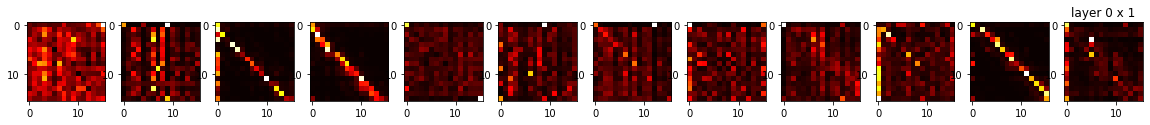

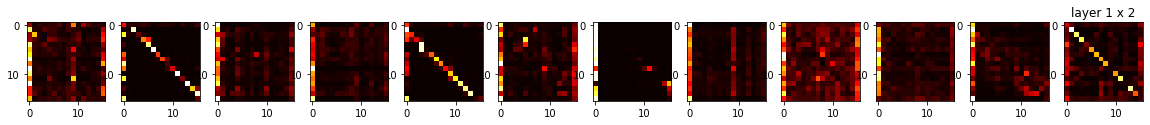

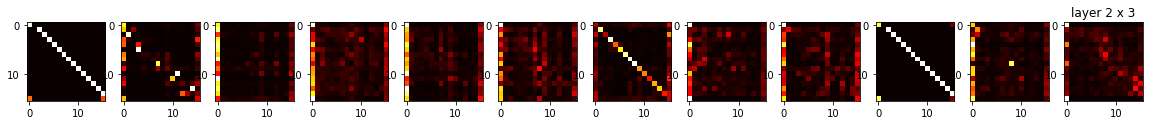

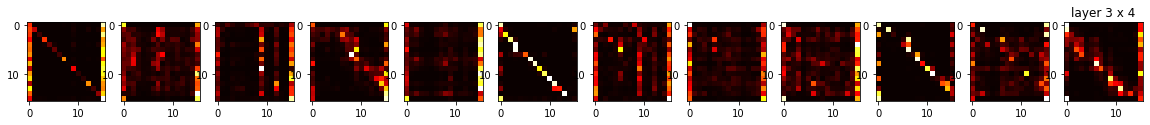

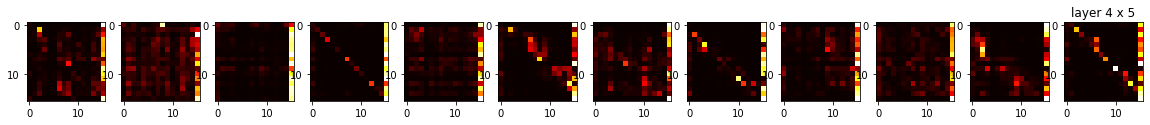

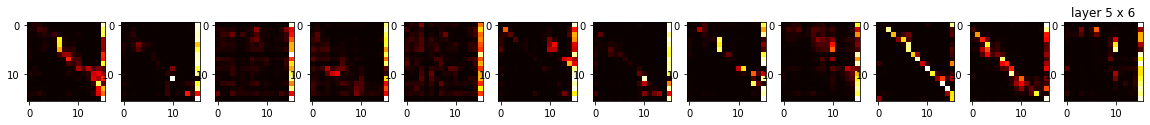

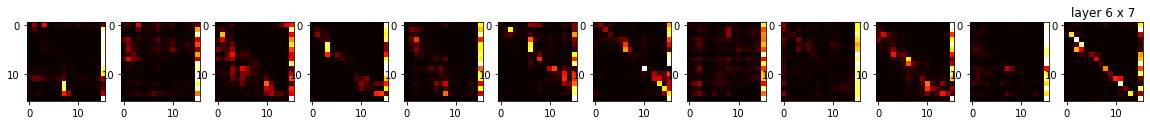

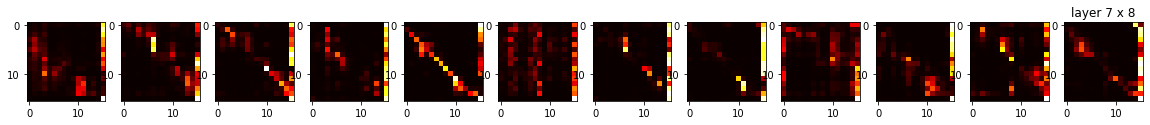

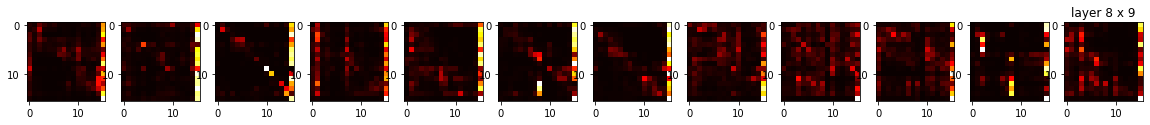

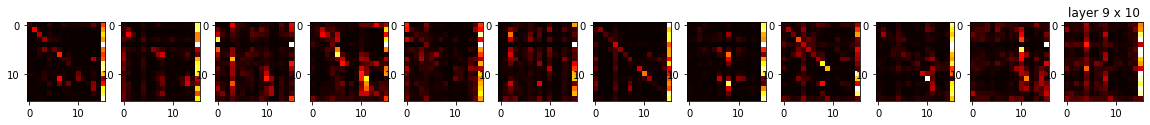

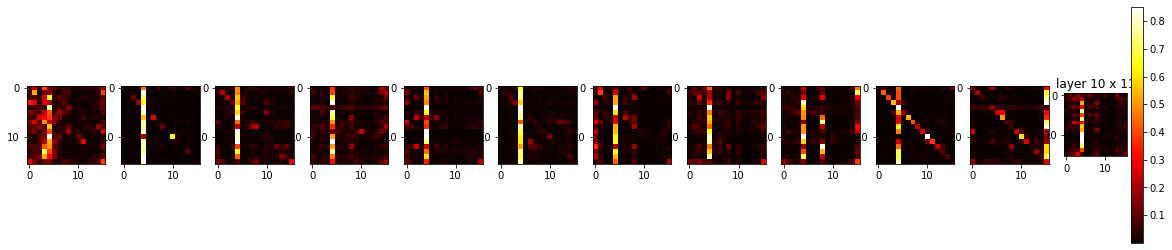

In [ ]:
similarity = plot_layer_head_similarity(output.attentions)

In [ ]:
layers = get_layers(output.attentions)
layers.shape

(12, 12)

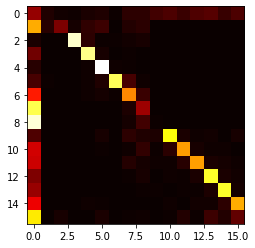

In [ ]:
plt.imshow(layers[1][1], cmap='hot', interpolation='nearest')

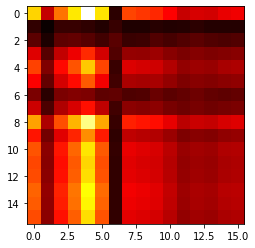

In [ ]:
ph = layers[1][2]
qh = layers[2][2]

result = our_similarity(ph,qh)
plt.imshow(result, cmap='hot', interpolation='nearest')

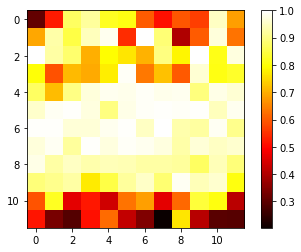

In [ ]:
per_head(layers, np.max)

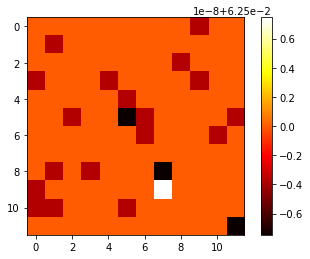

In [ ]:
per_head(layers, np.average)

In [ ]:
np.average(layers[9][7])

0.06250001

In [ ]:
def for_input(input, fn):
  input = input.unsqueeze(0)
  output = model(input)
  layers = get_layers(output.attentions)
  per_head(layers, fn)

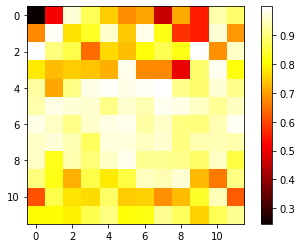

In [ ]:
for_input(input_ids[1], np.max)

In [ ]:
%pip install sentencepiece
%pip install transformers

In [75]:
from transformers import MarianMTModel, MarianTokenizer

lang = "en"
target_lang = "es"
model_name = f'Helsinki-NLP/opus-mt-{lang}-{target_lang}'
model = MarianMTModel.from_pretrained(model_name, output_attentions=True)
tokenizer = MarianTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

In [101]:

batch = tokenizer([". If axis is negative it counts from the last to the first axis. If axis is a tuple of ints, flipping is performed on all of the axes specified in the tuple."], return_tensors="pt", padding=True)
                
batch["input_ids"] = batch["input_ids"][:, :512]
# batch["attention_mask"] = batch["attention_mask"][:, :512]

translation = model.generate(**batch)
translated = tokenizer.batch_decode(translation, skip_special_tokens=True)
translated

['. Si el eje es negativo cuenta desde el último hasta el primer eje. Si el eje es una tupla de ints, se realiza la volteo en todos los ejes especificados en la tupla.']

In [102]:
translation.shape

torch.Size([1, 45])

In [103]:
translation

tensor([[65000,    25,     3,   216,    14, 12309,    43, 13070,   363,   253,
            14,  1439,   302,    14,   787, 12309,     3,   216,    14, 12309,
            43,    38,   213,  9231,     4,    25,  5204,     9,     2,    26,
          4979,     6,  5971, 12755,    12,   154,    17, 22576, 30170,    12,
             6,   213,  9231,     3,     0]])

In [104]:
translated_ids = batch = tokenizer(translated, return_tensors="pt", padding=True)
translated_ids["input_ids"] = translated_ids["input_ids"][:, :512]

In [105]:
output = model(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"])

In [106]:
output.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

In [107]:
def plot_layer_head_func(attention, num_layers=12, num_heads=12, fn=None):
  layers = np.ndarray((num_layers,num_heads), np.ndarray)
  for i in range(0,num_layers):
    p = attention[i].detach().cpu().numpy()
    q = attention[i+1].detach().cpu().numpy()
    fig, axis = plt.subplots(1,num_heads, figsize=(20,5), facecolor='w', edgecolor='k')
    plt.title(f'layer {i} x {i+1}')
    head = 0
    for axs, ph, qh in zip(axis.flatten(), p[0], p[0]):

      if not fn:
        fn = (lambda x: x)
      result = fn(ph)
      heatmap = axs.imshow(result, cmap='hot')

      # plt.title(f'head {head}')
      layers[i, head] = result
      head += 1
  plt.colorbar(heatmap)
  return layers


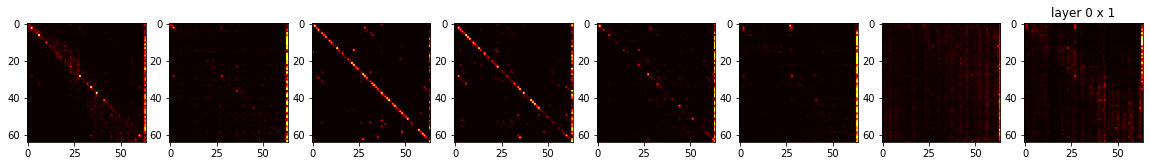

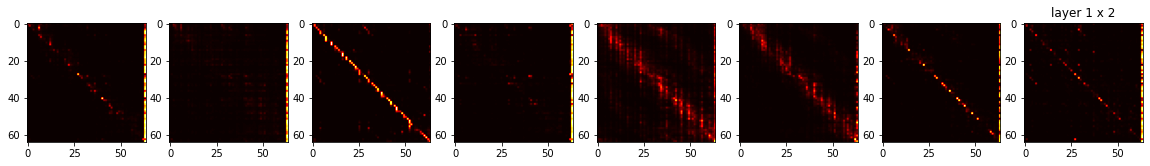

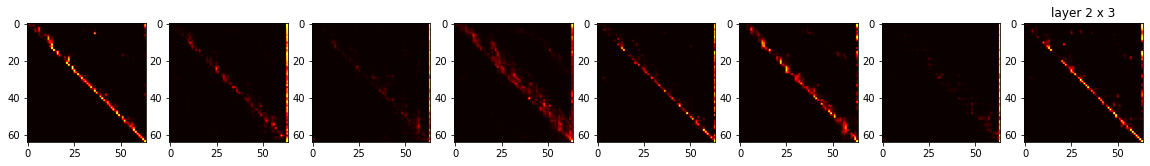

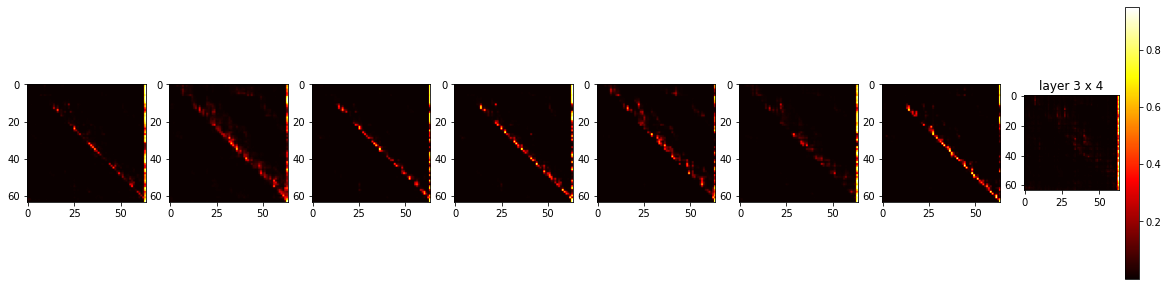

In [108]:
similarities = plot_layer_head_func(output.cross_attentions, 4, 8)

In [ ]:
plt.imshow(output.[1][1], cmap='hot', interpolation='nearest')

In [66]:
!pip install datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [67]:
from datasets import load_dataset

dataset = load_dataset("Fraser/news-category-dataset")

Using custom data configuration default
Reusing dataset news_category (/root/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


In [68]:
import pandas as pd

In [69]:
train_news = pd.DataFrame(dataset['train'])

In [70]:
x = train_news[train_news['category'] == 'POLITICS']
len(political_news)

26127

In [71]:
x.values[0][-1]

'Conservatives in all corners of the globe must have felt their hearts sing, if only for a moment, when the Financial Times ran a piece entitled "Piketty findings undercut by errors." Sadly for them, the FT\'s claims proved untrue.'

In [72]:
train_news['category'].unique()

array(['COMEDY', 'ARTS', 'BUSINESS', 'TRAVEL', 'POLITICS', 'EDUCATION',
       'ENTERTAINMENT', 'GREEN', 'TECH', 'THE WORLDPOST', 'RELIGION',
       'PARENTING', 'WOMEN', 'WELLNESS', 'HEALTHY LIVING', 'WORLD NEWS',
       'BLACK VOICES', 'HOME & LIVING', 'FOOD & DRINK', 'PARENTS',
       'DIVORCE', 'SCIENCE', 'QUEER VOICES', 'STYLE & BEAUTY', 'WEDDINGS',
       'ARTS & CULTURE', 'IMPACT', 'STYLE', 'CRIME', 'WEIRD NEWS',
       'MEDIA', 'COLLEGE', 'TASTE', 'MONEY', 'CULTURE & ARTS', 'SPORTS',
       'WORLDPOST', 'FIFTY', 'GOOD NEWS', 'ENVIRONMENT', 'LATINO VOICES'],
      dtype=object)

In [73]:
y = train_news[train_news['category'] == 'PARENTS']

In [76]:
y.values[11][-1]

'Bringing a baby into this world is truly a miracle and I can confidently say that the past 12 months have been the best 12 months of my entire life. This post is my take on being a father, and the top 10 lessons I learned.'

In [86]:
example1 = x.values[27][-1]
example1

"The senator wants legislation and a hearing to address pharmaceutical companies' role in the opioid epidemic."

In [113]:
example2 = y.values[11][-1].split('. ')[1]
example2

'This post is my take on being a father, and the top 10 lessons I learned.'

In [114]:
batch1 = tokenizer([example1], return_tensors="pt", padding=True)
batch1["input_ids"] = batch1["input_ids"][:, :512]

In [115]:
batch2 = tokenizer([example2], return_tensors="pt", padding=True)
batch2["input_ids"] = batch2["input_ids"][:, :512]

In [116]:
batch1.keys()

dict_keys(['input_ids', 'attention_mask'])

In [117]:
output1 = model(input_ids=batch1["input_ids"], decoder_input_ids=batch1["input_ids"])
output2 = model(input_ids=batch2["input_ids"], decoder_input_ids=batch2["input_ids"])

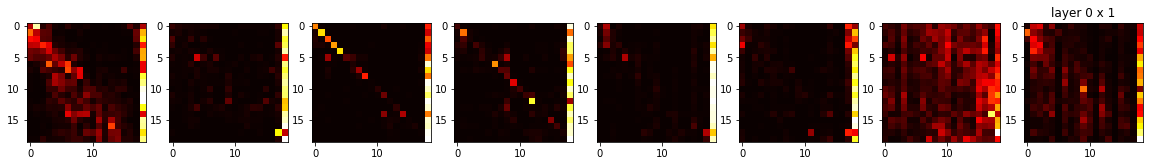

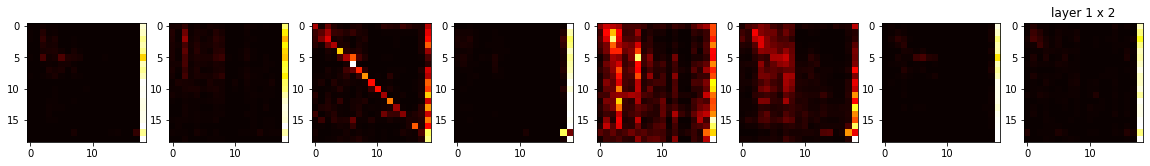

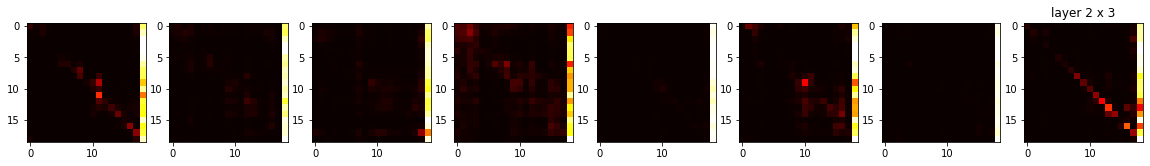

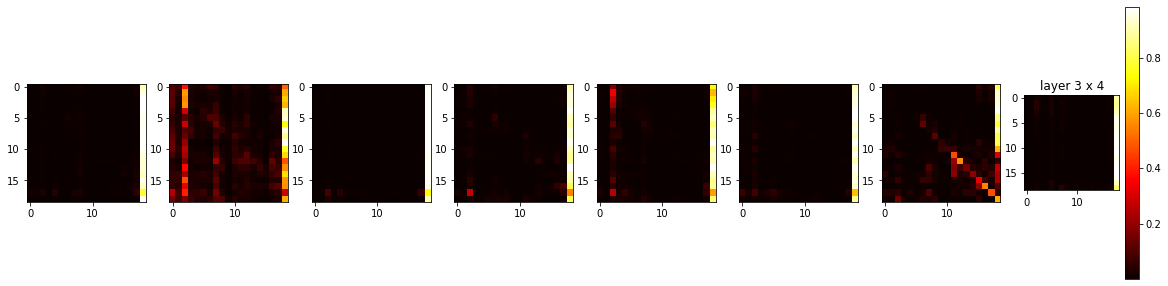

In [122]:
attention1 = plot_layer_head_func(output1.cross_attentions, 4, 8)

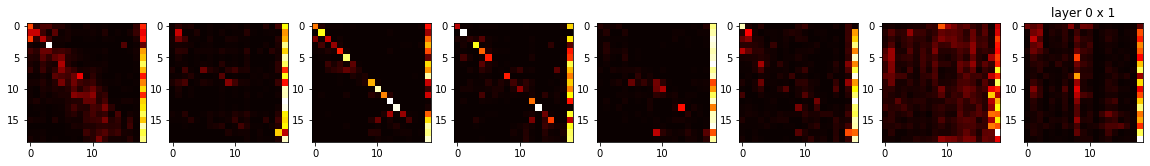

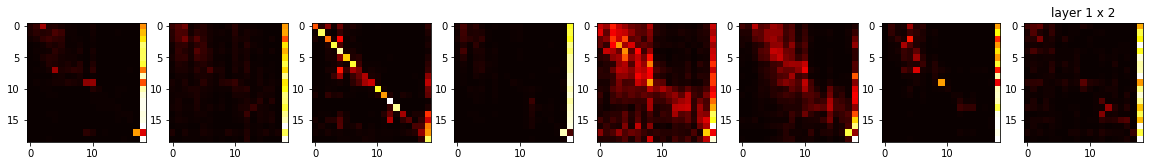

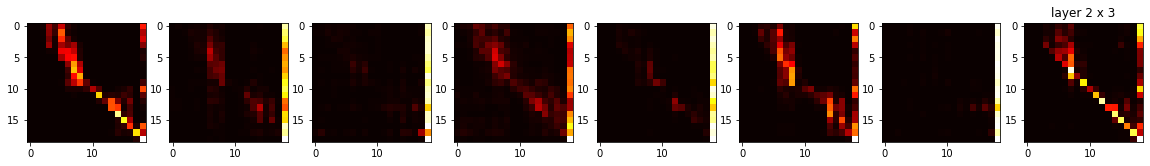

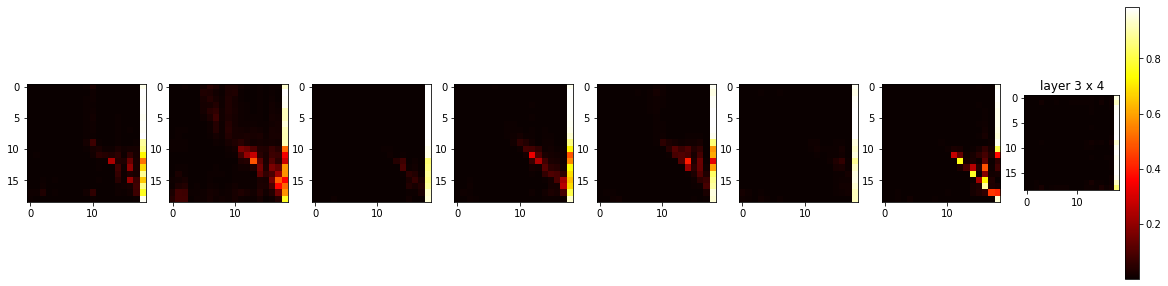

In [119]:
attention2 = plot_layer_head_func(output2.cross_attentions, 4, 8)

In [200]:
def get_layers(attention, num_layers=12, num_heads=12):
  layers = np.ndarray((num_layers,num_heads), np.ndarray)
  for i, layer in enumerate(attention):
    layer = layer.detach().cpu().numpy()[0]
    for j, head in enumerate(layer):
      layers[i,j] = head
  return layers

def per_head(layers, fn, num_layers=12, num_heads=12):
  result = np.ndarray((num_layers,num_heads), float)

  for layer in range(0,num_layers):
    for head in range (0,num_heads):
      result[layer, head] = fn(layers[layer, head])
  return result

def for_input(model, tokenizer, input, fn):
  tokenized = tokenizer([example1], return_tensors="pt", padding=True) 
  input = tokenized["input_ids"][:, :512]
  output = model(input_ids=input, decoder_input_ids=input)
  print(output.keys())
  attention = get_layers(output.cross_attentions)
#   return layers
  return per_head(attention, fn, 4, 8)
    

In [201]:
#   example = x.values[100][-1]
# example = 'this is a sentence'
  result = for_input(model, tokenizer, example, np.max)

plt.imshow(result, cmap='hot', interpolation='nearest')
#   plt.colorbar(plot)

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])


'hello'

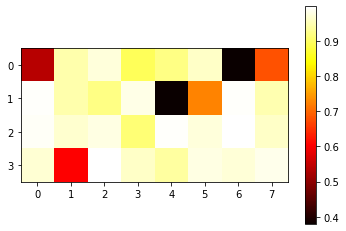

In [202]:
'hello'